In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from flashbax.vault import Vault
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
import pandas as pd
import seaborn as sns
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState
import pickle
import seaborn as sns

# this is the most NB
from og_marl.coverage_notebooks.produce_count_info_efficient import *

# Aim: Get the probability that a pair will give rise to the same reward twice
We start with:
- values, reverse indexes (for rebuilding/reference back to original vault), counts, bucketed rewards

We want the following:
- probabilities to quanitfy uncertainty in the dataset

In [13]:
rel_dir="/home/louise/workspace/og-marl/vaults/og_marl/smac_v1"
vault_name = "3m.vlt"
keys = ["state","joint","agent0","agent1","agent2"]
uids = ["Good","Medium","Poor"]

counts_over_datasets = {}

for uid in uids:
    try:
        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            counts_over_datasets[uid] = pickle.load(f)
    except:
        keys = create_count_information(rel_dir,vault_name,uid,store_raw_reward_info=True)
        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            counts_over_datasets[uid] = pickle.load(f)

Loading vault found at /home/louise/workspace/og-marl/vaults/og_marl/smac_v1/3m.vlt/Medium
Loading vault found at /home/louise/workspace/og-marl/vaults/og_marl/smac_v1/3m.vlt/Poor


In [18]:
def plot_oaco(rel_dir,vault_name,vault_uids,random_dataset_pos=-2,norm_wrt_state=False):
    num_unique = {}
    for uid in vault_uids:
        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)

    unique_df = pd.DataFrame(num_unique)
    unique_df.transpose

    fig, ax = plt.subplots(1,1,figsize=(13,4))

    # normalise wrt random if random dataset exists
    if random_dataset_pos!=-2:
        unique_df = unique_df.div(unique_df.iloc[:,random_dataset_pos],axis=0)

    # normalise wrt random if random dataset exists
    if norm_wrt_state:
        unique_df = unique_df.div(unique_df.iloc[-1,:],axis=1)

    sns.heatmap(unique_df,annot=True,fmt='.0f',square=False)
    # plt.title(vault_name)
    plt.xticks(rotation=30, ha='right')
    plt.savefig(rel_dir+"/"+vault_name+"/"+"OACo_heatmap.pdf",format='pdf',bbox_inches='tight')
    plt.show()
    return

-2


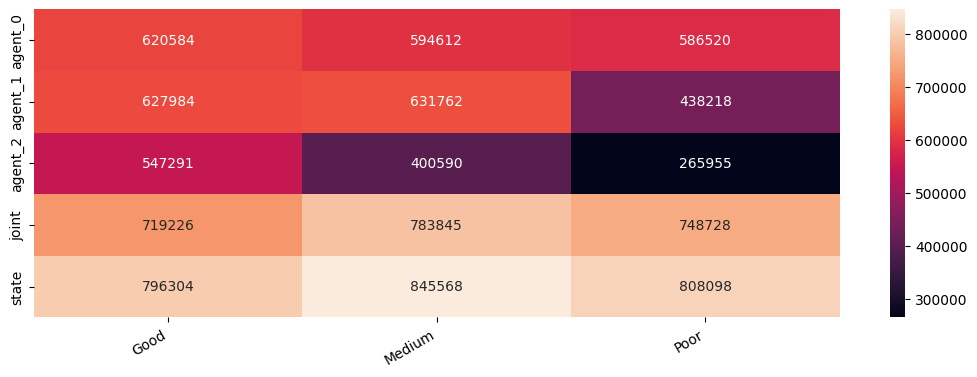

In [20]:
plot_oaco(rel_dir,vault_name,["Good","Medium","Poor"],norm_wrt_state=False)

In [3]:
samples = 100000


probs = {}

for key in keys:
    len_vals = []
    probs[key] = {}
    # for the joint
    for i,uid in enumerate(uids):
        (vals,indices,counts, rewards) = counts_over_datasets[uid]

        repeat_indices = np.where(counts[key]>1)
        
        rewards_repeat = [rewards[key][j] for j in repeat_indices[0]]

        num_repeated = 0

        selected = np.random.randint(0,len(rewards_repeat),size = samples)

        for reward_bucket_idx in selected:
            a,b = np.random.choice(rewards_repeat[reward_bucket_idx],size=2,replace=False)
            if a==b:
                num_repeated+=1

        if key=="state" and uid=="Replay":
            print(rewards_repeat)
        # print(num_repeated/samples)
        probs[key][uid] = num_repeated/samples


In [4]:
print("\t \t"+str(keys))
for uid in uids:
    print("")
    print(uid+':   \t',end="")
    for key in keys:
        print(probs[key][uid],end="\t")


	 	['state', 'joint', 'agent0', 'agent1', 'agent2', 'agent3', 'agent4']

Good:   	1.0	0.56839	0.64329	0.66097	0.66651	0.68723	0.70186	
Medium:   	1.0	0.65851	0.69252	0.70892	0.71334	0.7189	0.76263	
Poor:   	1.0	0.88368	0.84357	0.90575	0.88118	0.87764	0.88269	
Replay_IDRQN:   	0.34528	0.75245	0.81803	0.82848	0.81746	0.82686	0.81816	
Replay_QMIX:   	0.32596	0.73155	0.8569	0.80684	0.83915	0.82836	0.82406	
Random:   	0.9391	1.0	0.99196	0.99586	0.99526	0.99609	0.99825	

In [5]:
# the same as above, but exhaustive
probs = {}

probs_array = np.zeros((len(keys),len(uids)))
print(keys)
print(uids)

num_repeated_occurrences = np.zeros((len(keys),len(uids)))

for k,key in enumerate(keys):
    len_vals = []
    probs[key] = {}
    # for the joint
    for i,uid in enumerate(uids):
        (vals,indices,counts, rewards) = counts_over_datasets[uid]

        repeat_indices = np.where(counts[key]>1)
        
        rewards_repeat = [rewards[key][j] for j in repeat_indices[0]]

        total_transitions_available = np.sum([len(bucket) for bucket in rewards_repeat])
        # print(total_transitions_available)

        prob_of_repeat = 0

        for reward_bucket in rewards_repeat:
            len_bucket = len(reward_bucket)
            prob_of_bucket = len_bucket/total_transitions_available
            reward_vals, reward_counts = np.unique(reward_bucket,return_counts=True)

            prob_2_rewards_the_same = 0

            for reward_count in reward_counts:
                prob_of_reward_given_bucket = reward_count/len_bucket
                prob_of_second_chosen_reward_same_as_first = (reward_count-1)/(len_bucket-1)

                prob_2_rewards_the_same +=  prob_of_reward_given_bucket*prob_of_second_chosen_reward_same_as_first
            
            prob_of_repeat += prob_of_bucket*prob_2_rewards_the_same
            
        # print(num_repeated/samples)
        probs[key][uid] = prob_of_repeat
        probs_array[k][i] = prob_of_repeat
        num_repeated_occurrences[k][i] = total_transitions_available


['state', 'joint', 'agent0', 'agent1', 'agent2', 'agent3', 'agent4']
['Good', 'Medium', 'Poor', 'Replay_IDRQN', 'Replay_QMIX', 'Random']


Text(0.5, 1.0, 'terran_5_vs_5')

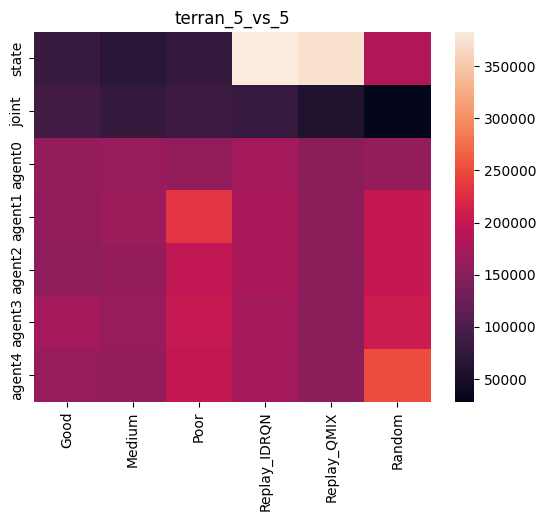

In [6]:
sns.heatmap(num_repeated_occurrences,xticklabels=uids,yticklabels=keys)
plt.title("terran_5_vs_5")
# plt.savefig(rel_dir+"/"+vault_name+"/"+"prob_repeat_reward_heatmap.png")

In [7]:
float_formatter = "{:.2f}".format
print("\t    "+str(keys))
for uid in uids:
    print("")
    print(uid+':   \t',end="")
    for key in keys:
        print(float_formatter(probs[key][uid]),end="\t  ")


	    ['state', 'joint', 'agent0', 'agent1', 'agent2', 'agent3', 'agent4']

Good:   	1.00	  0.94	  0.62	  0.64	  0.64	  0.60	  0.62	  
Medium:   	1.00	  0.93	  0.58	  0.57	  0.59	  0.58	  0.59	  
Poor:   	1.00	  0.98	  0.69	  0.52	  0.58	  0.57	  0.58	  
Replay_IDRQN:   	0.47	  0.96	  0.59	  0.58	  0.57	  0.59	  0.58	  
Replay_QMIX:   	0.45	  0.94	  0.55	  0.54	  0.53	  0.53	  0.54	  
Random:   	0.95	  1.00	  0.75	  0.72	  0.72	  0.72	  0.70	  

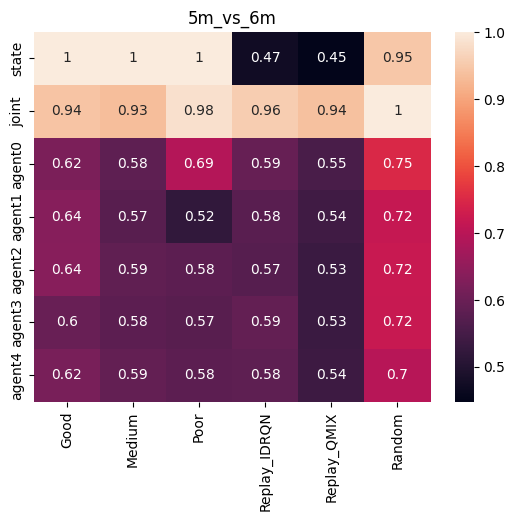

In [8]:
sns.heatmap(probs_array,xticklabels=uids,yticklabels=keys,annot=True)
plt.title("5m_vs_6m")
plt.savefig(rel_dir+"/"+vault_name+"/"+"prob_repeat_reward_heatmap.png")

The difference lies in the fact that not that many rewards are available and some are more common than others.

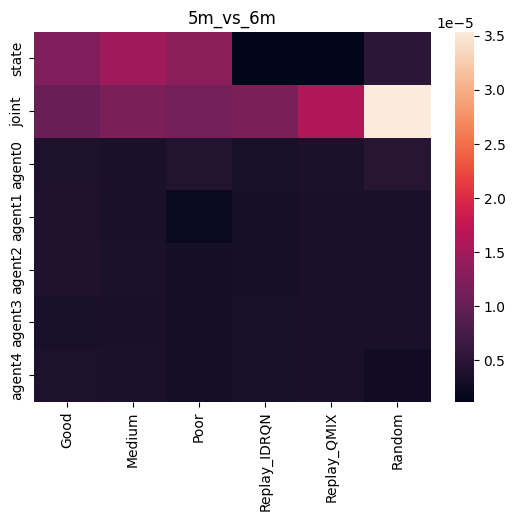

In [10]:
sns.heatmap(probs_array/num_repeated_occurrences,xticklabels=uids,yticklabels=keys)
plt.title("5m_vs_6m")
plt.savefig(rel_dir+"/"+vault_name+"/"+"prob_repeat_reward_heatmapnormed.png")

In [14]:
def di_funct(a,b):
    sum = a+b
    return (a/sum*((a-1)/(sum-1)))+(b/sum*((b-1)/(sum-1)))

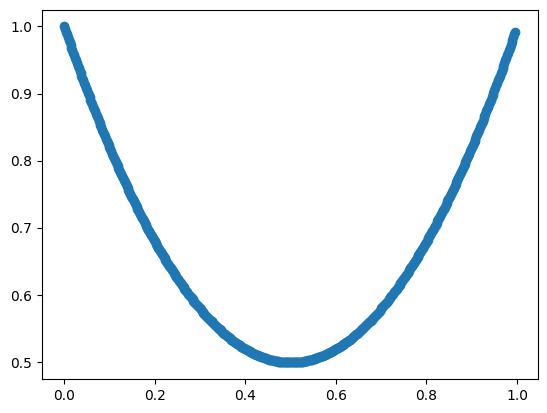

: 

In [23]:
aa = np.array(list(range(500)))
bb = 501-np.array(aa)

xx = aa/(aa+bb)

yy = di_funct(aa,bb)

plt.scatter(xx,yy)

Here is what is happening (kind of): when we have a super unbalanced dataset, it is always a lot better for reward variability.